## Multimodal RAG Pipeline for Excel files with ColQwen2
This notebook introduce an approach to improve Multimodal RAG by integrating **ColQwen** into the pipeline. Compared to traditional RAG methods, this enhanced technique demonstrates greater robustness and effectiveness when processing complex, unstructured files. The original idea of this apporoach is Colpali, which is introduce in [this paper](https://arxiv.org/abs/2407.01449).

## Why ColQwen2?
ColQwen2 is a model designed to leverage VLMs to construct efficient multi-vector embeddings in the visual space for document retrieval. Using ColQwen2 removes the need for potentially complex and brittle layout recognition and OCR pipelines with a single model that can take into account both the textual and visual content (layout, charts, ...) of a document. For a better understanding about this model, you can visit [this notebook](https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/run_e2e_rag_colqwen2_with_adapter_hot_swapping.ipynb).

---

## Imports:
This notebook leverages colpali-engine, the official implementation of ColPali and ColQwen2. This package also contains the training code (processor, collator, trainer...) for fine-tuning these models on your own dataset.

In [1]:
!pip install -q -U "colpali-engine>=0.3.1,<0.4.0" requests

In [2]:
# Install libgdiplus
# libgdiplus is required to use aspose-cell. If you run this notebook on linux, make sure you have installed this.
!apt-get install -y libgdiplus

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libexif12
The following NEW packages will be installed:
  libexif12 libgdiplus
0 upgraded, 2 newly installed, 0 to remove and 72 not upgraded.
Need to get 252 kB of archives.
After this operation, 955 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libexif12 amd64 0.6.24-1build1 [92.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libgdiplus amd64 6.0.4+dfsg-2 [160 kB]
Fetched 252 kB in 1s (504 kB/s)    
Selecting previously unselected package libexif12:amd64.
(Reading database ... 122997 files and directories currently installed.)
Preparing to unpack .../libexif12_0.6.24-1build1_amd64.deb ...
Unpacking libexif12:amd64 (0.6.24-1build1) ...
Selecting previously unselected package libgdiplus.
Preparing to unpack .../libgdiplus_6.0.4+dfsg-2_amd64.deb ...
Unpacking libgdiplu

In [3]:
# !ln -s /usr/lib/libgdiplus.so gdiplus.dll

In [4]:
# Install required library
!pip install aspose-cells-python==24.12.0 PyMuPDF==1.25.1 llama-index==0.12.5 llama-index-multi-modal-llms-gemini==0.4.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.6/91.6 MB 18.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 79.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.9/164.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.0/345.0 kB 22.7 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
  Attempting uninstall: certifi
    Found ex

In [5]:
import io
from typing import Any, List, cast
import nest_asyncio
import aspose.cells as ac
from aspose.cells import SaveFormat, Workbook
import tempfile
import os
import fitz  # PyMuPDF
from llama_index.core.prompts import PromptTemplate
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
from llama_index.core.schema import ImageDocument

import requests
import torch
from colpali_engine.models import ColQwen2, ColQwen2Processor
from colpali_engine.utils.torch_utils import get_torch_device
from IPython.display import display
from peft import LoraConfig
from PIL import Image
from transformers.models.qwen2_vl import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

In [6]:
nest_asyncio.apply()

In [7]:
def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    scaled_image = image.resize((new_width, new_height))

    return scaled_image

## Load ColQwen2
Click on the following link to open the model card for [vidore/colqwen2-v1.0](https://huggingface.co/vidore/colqwen2-v1.0)

In [8]:
model_name = "vidore/colqwen2-v1.0"
device = get_torch_device("auto")

print(f"Using device: {device}")

# Get the LoRA config from the pretrained retrieval model
lora_config = LoraConfig.from_pretrained(model_name)

# Load the processors
processor_retrieval = cast(ColQwen2Processor, ColQwen2Processor.from_pretrained(model_name))

# Load the model with the loaded pre-trained adapter for retrieval
model = cast(
    ColQwen2,
    ColQwen2.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
)

Using device: cuda:0


adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

## Import excel file and take screenshot of each sheet to feed into Colqwen2
File used for demonstration [here](https://www.teamgantt.com/downloads/excel-gantt-chart-template)

In [9]:
file_dir = "/kaggle/input/ragxlsx/TeamGantt.xlsx"
workbook = Workbook(file_dir)
new_wb = Workbook()

# Loop through each sheet in the original workbook
for i in range(len(workbook.worksheets)):
    single_sheet = workbook.worksheets[i]

    # Set page setup for the sheet
    single_sheet.page_setup.orientation = ac.PageOrientationType.LANDSCAPE
    single_sheet.page_setup.fit_to_pages_wide = 1
    single_sheet.page_setup.fit_to_pages_tall = 1

    # Add a new worksheet to the new workbook if it doesn't exist
    if i >= len(new_wb.worksheets):
        new_wb.worksheets.add()

    # Copy the content from the source sheet to the new workbook's sheet
    new_sheet = new_wb.worksheets[i]
    new_sheet.copy(single_sheet)

# new_wb.save(os.path.join(main_dir, output_dir, "fsheet.pdf"), save_format=SaveFormat.PDF)

In [10]:
# Save the PDF to a BytesIO stream
pdf_stream = io.BytesIO()
new_wb.save(pdf_stream, SaveFormat.PDF)

In [11]:
# Ensure the stream position is reset before reading
pdf_stream.seek(0)

# Load the PDF directly into fitz
pdf_document = fitz.open(stream=pdf_stream, filetype="pdf")
images = []

# Now you can work with the PDF document in memory
for page_number in range(len(pdf_document)):
    page = pdf_document[page_number]
    pix = page.get_pixmap(dpi=300)

    # Convert Pixmap to PIL Image
    mode = "RGB" if pix.n < 4 else "RGBA"  # Determine the color mode
    images.append(Image.frombytes(mode, [pix.width, pix.height], pix.samples))

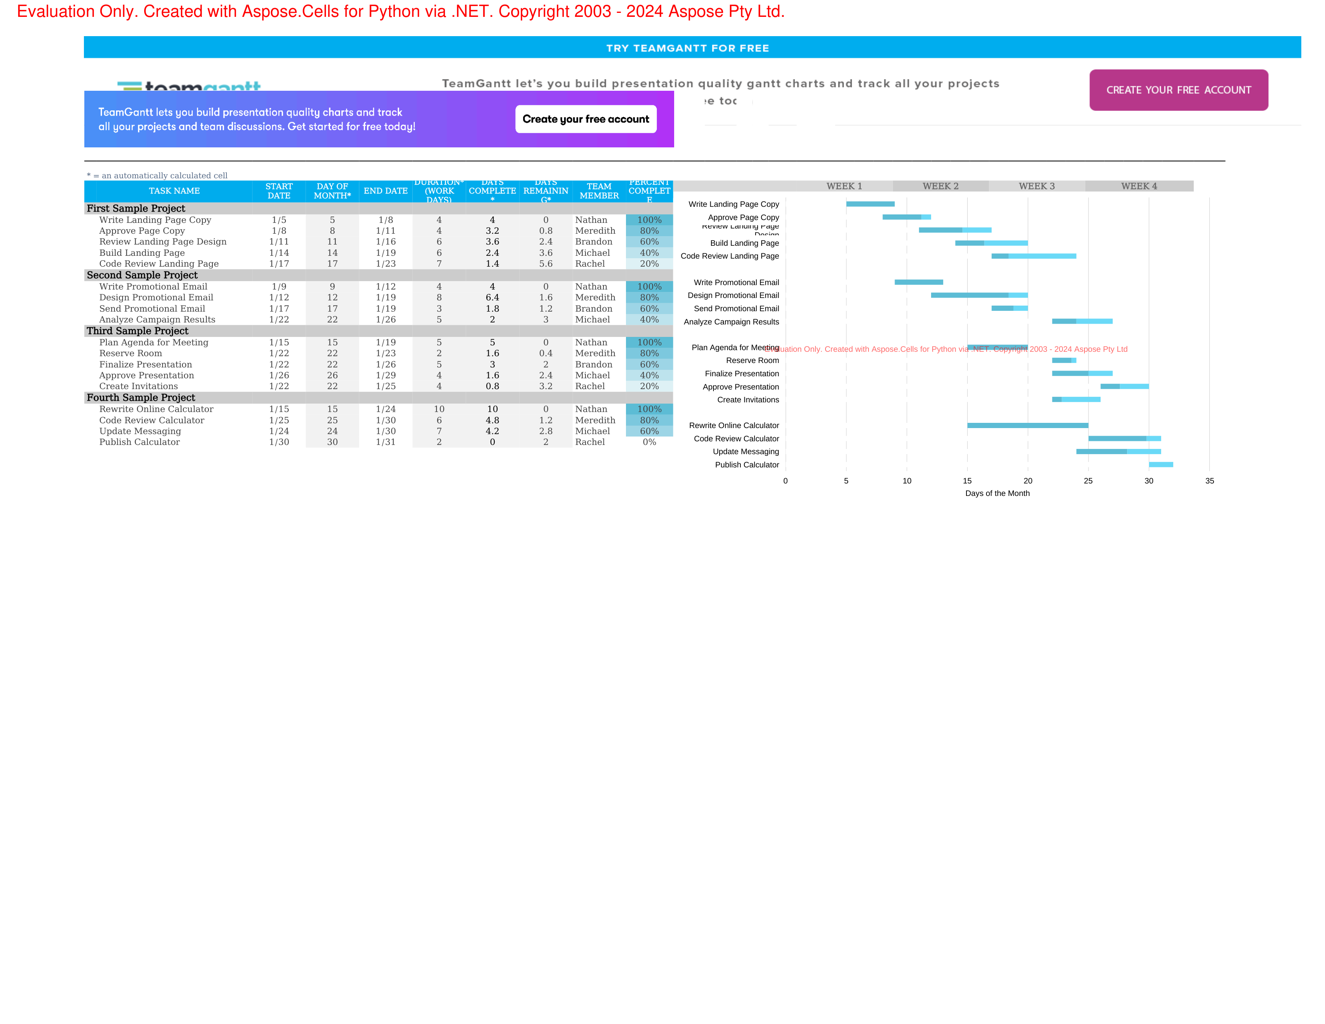

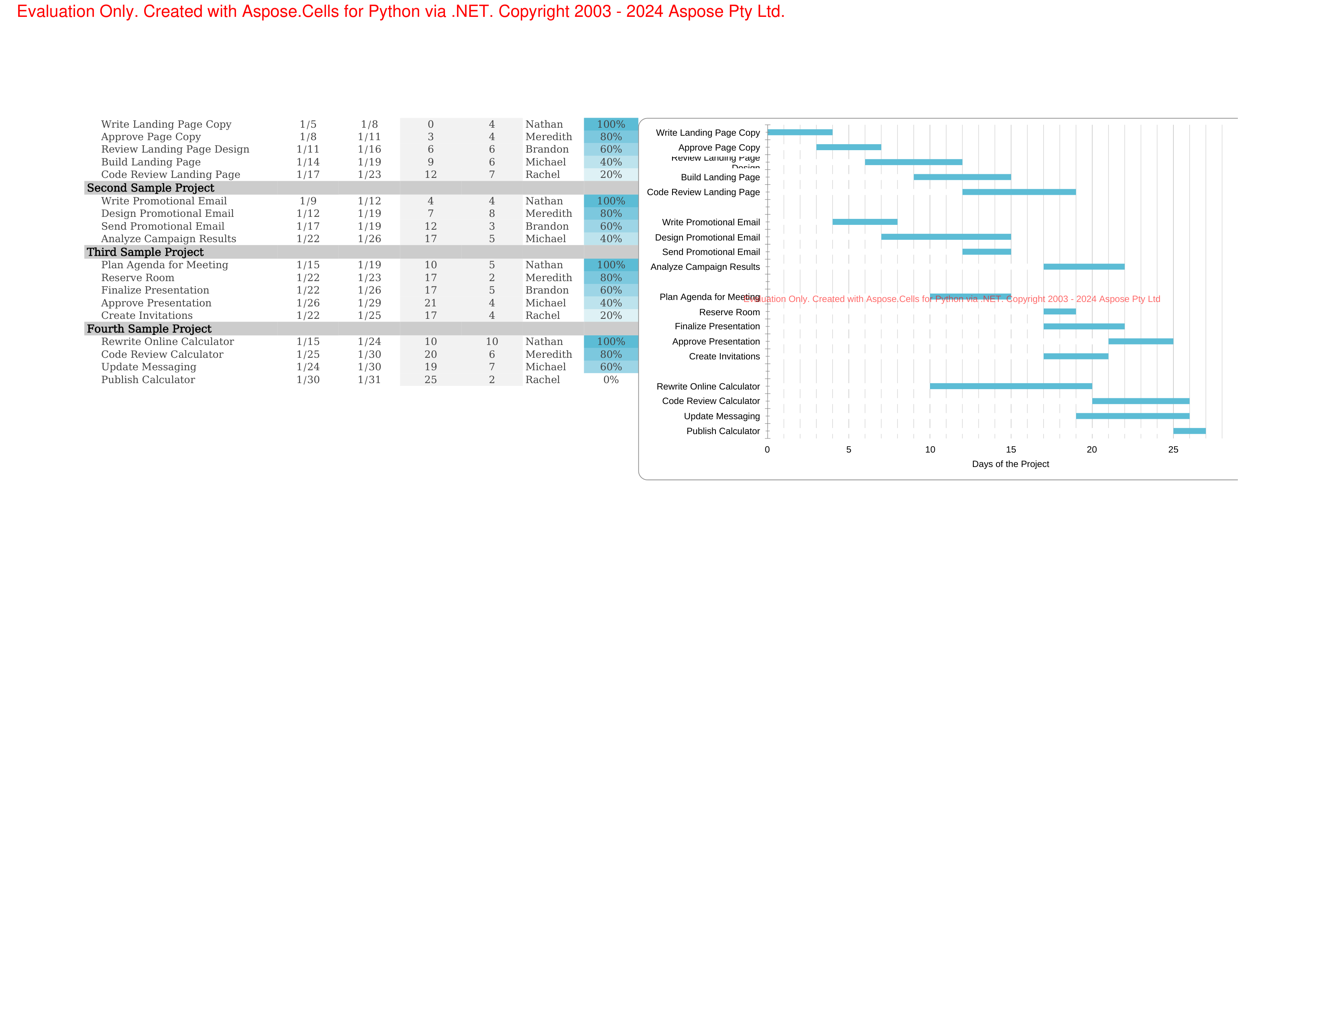

In [12]:
# NOTE: Because ColQWen2 uses dynamic resolution, we will scale down the images to prevent VRAM overload and faster
# inference times for both indexing and generation. From my experiments, a scale of 512 pixels is a good default for
# document tasks. Feel free to experiment with higher resolutions, especially if the text on your document is small.
images = [scale_image(image, new_height=1024) for image in images]
# images = images[:1]

for image in images:
    display(scale_image(image, new_height=1024))

## Create and store embedding of documents

In [13]:
#Process images in batches to avoid VRAM overload. Adjust this base on your hardware
def process_images_in_batches(images, processor_retrieval, model, batch_size=32):
    all_embeddings = []

    # Process images in smaller batches
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i+batch_size]

        # Process current batch
        batch_processed = processor_retrieval.process_images(batch_images).to(model.device)

        with torch.no_grad():
            batch_embeddings = model.forward(**batch_processed)

        # Collect embeddings for this batch
        all_embeddings.append(batch_embeddings)

    # Concatenate embeddings from all batches
    return torch.cat(all_embeddings, dim=0)

In [14]:
image_embeddings = process_images_in_batches(
    images,
    processor_retrieval,
    model,
    batch_size=2  # Adjust based on your GPU memory
)

## Retrieval and generation

This notebook utilizes the Gemini-1.5-Flash model, but you can substitute it with any other model capable of image understanding.

In [15]:
#Change this cell to import your own API key
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("GEMINI_API_KEY")

In [16]:
query = "which weeks does building landing page of the first project phase occured in? prioritize information on the gantt chart"

Image retrieved for the following query: `which weeks does building landing page of the first project phase occured in? prioritize information on the gantt chart`


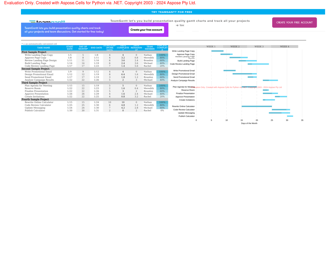

In [17]:
batch_queries = processor_retrieval.process_queries([query]).to(model.device)
with torch.no_grad():
    query_embeddings = model.forward(**batch_queries)

# Calculate the similarity scores
scores = processor_retrieval.score_multi_vector(query_embeddings, image_embeddings)

# Get the top-1 page image
retrieved_image_indices = scores.topk(k=1).indices[0]
retrieved_images = [images[idx] for idx in retrieved_image_indices]

for image in retrieved_images:
    print(f"Image retrieved for the following query: `{query}`")
    display(scale_image(image, new_height=256))

In [18]:
#Turn retrieved document into image node to send it to LLM
def images_to_nodes(pil_images):
    """
    Convert a list of PIL images to LlamaIndex image nodes.
    
    Args:
        pil_images (list): List of PIL Image objects
    
    Returns:
        list: List of LlamaIndex ImageDocument nodes
    """
    image_nodes = []
    
    for pil_image in pil_images:
        # Create a temporary file to save the image
        with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as temp_file:
            # Save the PIL image to the temporary file
            pil_image.save(temp_file.name, format='PNG')
            temp_file_path = temp_file.name
        
        # Create an ImageDocument node
        try:
            image_node = ImageDocument(
                image_path=temp_file_path,
                image_height=pil_image.height,
                image_width=pil_image.width
            )
            
            image_nodes.append(image_node)
        except Exception as e:
            print(f"Error creating node for image: {e}")
            # Optionally, clean up the temporary file
            os.unlink(temp_file_path)
    
    return image_nodes

In [19]:
image_nodes = images_to_nodes(images)

In [20]:
QA_PROMPT_TMPL = """\
Below we give pages of a PDF documents in image format.

Given the context information and not prior knowledge, answer the query. Explain where you got the answer.
Try look over all the images provided to confirm your answer.

Query: {query_str}
Answer: """

In [21]:
qa_prompt = PromptTemplate(QA_PROMPT_TMPL)
fmt_prompt = qa_prompt.format(query_str=query)

In [22]:
multi_modal_llm = GeminiMultiModal(model_name = "models/gemini-1.5-flash", api_key=api_key)

In [23]:
llm_response = multi_modal_llm.complete(
            prompt=fmt_prompt,
            image_documents=image_nodes,
        )

In [24]:
str(llm_response)

'The Gantt chart shows that building the landing page for the first project phase occurred during **weeks 2 and 3**.'